# BNNs Early Tests, copied from Javier Antoran's repository

Code mostly from: [Javier Antoran's Bayesian Neural Networks GitHub repository](https://github.com/JavierAntoran/Bayesian-Neural-Networks)

In [ ]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip install GPy
import GPy
import pandas as pd
import zipfile
import urllib.request
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from sklearn.model_selection import KFold

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

ERROR: torch-0.4.1-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.
     |████████████████████████████████| 959 kB 8.4 MB/s 
     |████████████████████████████████| 71 kB 11.0 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565116 sha256=1e838ead7ff2ed41d15626f6368a533f3cff3d959943518ceb12ccd16223eac5
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=3bd128751452972a9d563772ea9a9833e3c6b33c11922af24a3e9ceeafe389f4
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz


In [ ]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla P100-PCIE-16GB'

In [ ]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

calculating losses

In [ ]:
def log_gaussian_loss(output, target, sigma, no_dim, sum_reduce=True):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    if sum_reduce:
        return -(log_coeff + exponent).sum()
    else:
        return -(log_coeff + exponent)


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

sampling

In [ ]:
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        scale = (2/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-3, -3))
        
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-4, -3))
        
    def forward(self, x, sample = True):
        
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the KL loss term
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples

In [ ]:
class BBP_Heteroscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(BBP_Heteroscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, num_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(num_units, 2*output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

In [ ]:
class BBP_Heteroscedastic_Model_Wrapper:
    def __init__(self, network, learn_rate, batch_size, no_batches):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
            fit_loss_total = fit_loss_total + fit_loss
        
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total
    
    def get_loss_and_rmse(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)
            means.append(output[:, :1, None])
            stds.append(output[:, 1:, None].exp())
            
        means, stds = torch.cat(means, 2), torch.cat(stds, 2)
        mean = means.mean(dim=2)
        std = (means.var(dim=2) + stds.mean(dim=2)**2)**0.5
            
        # calculate fit loss based on mean and standard deviation of output
        logliks = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1, sum_reduce=False)
        rmse = float((((mean - y)**2).mean()**0.5).cpu().data)

        return logliks, rmse

In [ ]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)

k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_mean = y[75:325].mean()
y_std = y[75:325].var()**0.5
y_train = (y[75:325] - y_mean)/y_std


num_epochs, batch_size, nb_train = 2000, len(x_train), len(x_train)

net = BBP_Heteroscedastic_Model_Wrapper(network=BBP_Heteroscedastic_Model(input_dim=1, output_dim=1, num_units=200),
                                        learn_rate=1e-2, batch_size=batch_size, no_batches=1)

fit_loss_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
total_loss = np.zeros(num_epochs)

best_net, best_loss = None, float('inf')

for i in range(num_epochs):
    
    fit_loss, KL_loss = net.fit(x_train, y_train, no_samples = 10)
    fit_loss_train[i] += fit_loss.cpu().data.numpy()
    KL_loss_train[i] += KL_loss.cpu().data.numpy()
    
    total_loss[i] = fit_loss_train[i] + KL_loss_train[i]
    
    if fit_loss < best_loss:
        best_loss = fit_loss
        best_net = copy.deepcopy(net.network)
        
    if i % 100 == 0 or i == num_epochs - 1:
        
        print("Epoch: %5d/%5d, Fit loss = %7.3f, KL loss = %8.3f" %
              (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i]))

        samples = []
        for i in range(100):
            preds = net.network.forward(torch.linspace(-3, 3, 200).cuda())[0]
            samples.append(preds.cpu().data.numpy()[:, 0])

Epoch:     1/ 2000, Fit loss = 355.431, KL loss = 2122.010
Epoch:   101/ 2000, Fit loss = 104.316, KL loss = 1836.494
Epoch:   201/ 2000, Fit loss =  95.512, KL loss = 1765.585
Epoch:   301/ 2000, Fit loss =  69.128, KL loss = 1701.091
Epoch:   401/ 2000, Fit loss =  66.324, KL loss = 1643.952
Epoch:   501/ 2000, Fit loss =  45.362, KL loss = 1588.294
Epoch:   601/ 2000, Fit loss =  52.558, KL loss = 1532.322
Epoch:   701/ 2000, Fit loss =  40.983, KL loss = 1474.382
Epoch:   801/ 2000, Fit loss =  27.533, KL loss = 1419.050
Epoch:   901/ 2000, Fit loss =  27.017, KL loss = 1370.871
Epoch:  1001/ 2000, Fit loss =  17.365, KL loss = 1329.558
Epoch:  1101/ 2000, Fit loss =  15.395, KL loss = 1287.507
Epoch:  1201/ 2000, Fit loss =  25.372, KL loss = 1247.564
Epoch:  1301/ 2000, Fit loss =  19.556, KL loss = 1213.938
Epoch:  1401/ 2000, Fit loss =  11.323, KL loss = 1181.054
Epoch:  1501/ 2000, Fit loss =  11.517, KL loss = 1152.398
Epoch:  1601/ 2000, Fit loss =  21.588, KL loss = 1124.5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

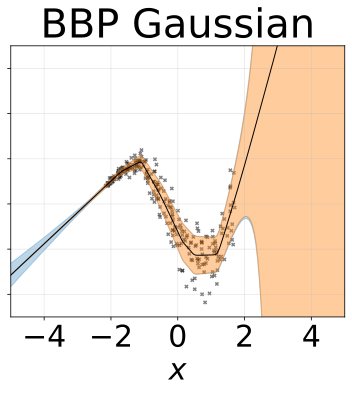

In [ ]:
samples, noises = [], []
for i in range(100):
    preds = best_net.forward(torch.linspace(-5, 5, 200).cuda())[0]
    samples.append(preds[:, 0].cpu().data.numpy()* y_std + y_mean)
    noises.append(preds[:, 1].exp().cpu().data.numpy()* y_std)

samples = np.array(samples)
noises = np.array(noises)
means = samples.mean(axis = 0)

aleatoric = (noises**2).mean(axis = 0)**0.5
epistemic = samples.var(axis = 0)**0.5
aleatoric = np.minimum(aleatoric, 10e3)
epistemic = np.minimum(epistemic, 10e3)

total_unc = (aleatoric**2 + epistemic**2)**0.5

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

x_mean, x_std = x_train.mean(), x_train.var()**0.5
plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train * x_std + x_mean, y_train * y_std + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200)* x_std + x_mean, means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('BBP Gaussian', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('bbp_hetero.pdf', bbox_inches = 'tight')

files.download("bbp_hetero.pdf")

plt.show()

UCI dataset fitting

In [ ]:
class BBP_Heteroscedastic_Model_UCI(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(BBP_Heteroscedastic_Model_UCI, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, num_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(num_units, num_units, gaussian(0, 1))
        self.layer3 = BayesLinear_Normalq(num_units, 2*output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

def train_BBP(data, n_splits, num_epochs, num_units, learn_rate, log_every):
    kf = KFold(n_splits=n_splits)
    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []

    for i, idx in enumerate(kf.split(data)):
        print('FOLD %d:' % i)

        train_index, test_index = idx

        x_train, y_train = data[train_index, :in_dim], data[train_index, in_dim:]
        x_test, y_test = data[test_index, :in_dim], data[test_index, in_dim:]

        x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
        y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5

        x_train = (x_train - x_means)/x_stds
        y_train = (y_train - y_means)/y_stds

        x_test = (x_test - x_means)/x_stds
        y_test = (y_test - y_means)/y_stds

        batch_size, nb_train = len(x_train), len(x_train)

        net = BBP_Heteroscedastic_Model_Wrapper(network=BBP_Heteroscedastic_Model_UCI(input_dim=x_test.shape[-1], output_dim=1, num_units=num_units),
                                                learn_rate=1e-2, batch_size=batch_size, no_batches=1)

        fit_loss_train = np.zeros(num_epochs)
        KL_loss_train = np.zeros(num_epochs)
        total_loss = np.zeros(num_epochs)

        best_net, best_loss = None, float('inf')

        for i in range(num_epochs):

            fit_loss, KL_loss = net.fit(x_train, y_train, no_samples = 20)
            fit_loss_train[i] += fit_loss.cpu().data.numpy()
            KL_loss_train[i] += KL_loss.cpu().data.numpy()

            total_loss[i] = fit_loss_train[i] + KL_loss_train[i]

            if fit_loss < best_loss:
                best_loss = fit_loss
                best_net = copy.deepcopy(net.network)

            if i % log_every == 0 or i == num_epochs - 1:

                train_losses, train_rmse = net.get_loss_and_rmse(x_train, y_train, 20)
                test_losses, test_rmse = net.get_loss_and_rmse(x_test, y_test, 20)

                print('Epoch: %s/%d, Train loglik = %.3f, Test loglik = %.3f, Train RMSE = %.3f, Test RMSE = %.3f' %\
                      (str(i+1).zfill(3), num_epochs, -train_losses.mean() - np.log(y_stds)[0],
                       -test_losses.mean() - np.log(y_stds)[0], y_stds*train_rmse, y_stds*test_rmse))


        train_losses, train_rmse = net.get_loss_and_rmse(x_train, y_train, 20)
        test_losses, test_rmse = net.get_loss_and_rmse(x_test, y_test, 20)

        train_logliks.append((train_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))
        test_logliks.append((test_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))

        train_rmses.append(y_stds*train_rmse)
        test_rmses.append(y_stds*test_rmse)

    print('Train log. lik. = %6.3f +/- %6.3f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var()**0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var()**0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var()**0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var()**0.5))

    return best_net

Housing dataset

In [ ]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data" --no-check-certificate 
data = pd.read_csv('housing.data', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

--2021-12-07 09:23:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49082 (48K) [application/x-httpd-php]
Saving to: ‘housing.data’

housing.data        100%[===================>]  47.93K   161KB/s    in 0.3s    

2021-12-07 09:23:23 (161 KB/s) - ‘housing.data’ saved [49082/49082]



In [ ]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

FOLD 0:
Epoch: 001/100, Train loglik = -3.635, Test loglik = -3.724, Train RMSE = 9.100, Test RMSE = 9.673
Epoch: 011/100, Train loglik = -3.304, Test loglik = -3.319, Train RMSE = 5.371, Test RMSE = 6.651
Epoch: 021/100, Train loglik = -2.826, Test loglik = -2.754, Train RMSE = 4.163, Test RMSE = 2.919
Epoch: 031/100, Train loglik = -2.676, Test loglik = -2.459, Train RMSE = 4.143, Test RMSE = 2.974
Epoch: 041/100, Train loglik = -2.466, Test loglik = -2.722, Train RMSE = 3.910, Test RMSE = 2.600
Epoch: 051/100, Train loglik = -2.462, Test loglik = -2.393, Train RMSE = 3.817, Test RMSE = 2.501
Epoch: 061/100, Train loglik = -2.451, Test loglik = -2.623, Train RMSE = 3.823, Test RMSE = 2.805
Epoch: 071/100, Train loglik = -2.326, Test loglik = -2.263, Train RMSE = 3.692, Test RMSE = 2.409
Epoch: 081/100, Train loglik = -2.228, Test loglik = -2.422, Train RMSE = 3.676, Test RMSE = 2.535
Epoch: 091/100, Train loglik = -2.343, Test loglik = -2.210, Train RMSE = 3.581, Test RMSE = 2.201
Ep

Concrete compressive dataset

In [ ]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls" --no-check-certificate
data = pd.read_excel('Concrete_Data.xls', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

--2021-12-07 09:24:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124928 (122K) [application/x-httpd-php]
Saving to: ‘Concrete_Data.xls.1’

Concrete_Data.xls.1 100%[===================>] 122.00K   275KB/s    in 0.4s    

2021-12-07 09:24:28 (275 KB/s) - ‘Concrete_Data.xls.1’ saved [124928/124928]



TypeError: ignored

In [ ]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

FOLD 0:
Epoch: 001/100, Train loglik = -3.618, Test loglik = -3.594, Train RMSE = 9.095, Test RMSE = 9.607
Epoch: 011/100, Train loglik = -3.218, Test loglik = -3.130, Train RMSE = 5.249, Test RMSE = 6.413
Epoch: 021/100, Train loglik = -2.704, Test loglik = -2.766, Train RMSE = 4.168, Test RMSE = 2.979
Epoch: 031/100, Train loglik = -2.558, Test loglik = -2.636, Train RMSE = 4.089, Test RMSE = 2.853
Epoch: 041/100, Train loglik = -2.535, Test loglik = -2.529, Train RMSE = 3.958, Test RMSE = 2.519
Epoch: 051/100, Train loglik = -2.450, Test loglik = -2.319, Train RMSE = 3.822, Test RMSE = 2.344
Epoch: 061/100, Train loglik = -2.424, Test loglik = -2.231, Train RMSE = 3.679, Test RMSE = 2.437
Epoch: 071/100, Train loglik = -2.265, Test loglik = -2.347, Train RMSE = 3.595, Test RMSE = 2.455
Epoch: 081/100, Train loglik = -2.230, Test loglik = -2.435, Train RMSE = 3.581, Test RMSE = 2.545
Epoch: 091/100, Train loglik = -2.267, Test loglik = -2.294, Train RMSE = 3.442, Test RMSE = 2.256
Ep


Energy efficiency dataset

In [ ]:
np.random.seed(0)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx" --no-check-certificate
data = pd.read_excel('ENB2012_data.xlsx', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

In [ ]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

Power dataset

In [ ]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip" --no-check-certificate 
zipped = zipfile.ZipFile("CCPP.zip")
data = pd.read_excel(zipped.open('CCPP/Folds5x2_pp.xlsx'), header=0, delimiter="\t").values
np.random.shuffle(data)

In [ ]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

Red wine dataset

In [ ]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv" --no-check-certificate 
data = pd.read_csv('winequality-red.csv', header=1, delimiter=';').values
data = data[np.random.permutation(np.arange(len(data)))]
data.shape

In [ ]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

Yacht dataset

In [ ]:
np.random.seed(0)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data" --no-check-certificate 
data = pd.read_csv('yacht_hydrodynamics.data', header=1, delimiter='\s+').values
data = data[np.random.permutation(np.arange(len(data)))]
data.shape

In [ ]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

MSCN Code from: [Andreas Kipf's Learned Cardinalities GitHub Repository](https://github.com/andreaskipf/learnedcardinalities)

# MSCN with BNN, based on Javier Antoran's repository


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Database_Project')

In [ ]:
import numpy as np


# Helper functions for data processing

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


def get_all_column_names(predicates):
    column_names = set()
    for query in predicates:
        for predicate in query:
            if len(predicate) == 3:
                column_name = predicate[0]
                column_names.add(column_name)
    return column_names


def get_all_table_names(tables):
    table_names = set()
    for query in tables:
        for table in query:
            table_names.add(table)
    return table_names


def get_all_operators(predicates):
    operators = set()
    for query in predicates:
        for predicate in query:
            if len(predicate) == 3:
                operator = predicate[1]
                operators.add(operator)
    return operators


def get_all_joins(joins):
    join_set = set()
    for query in joins:
        for join in query:
            join_set.add(join)
    return join_set


def idx_to_onehot(idx, num_elements):
    onehot = np.zeros(num_elements, dtype=np.float32)
    onehot[idx] = 1.
    return onehot


def get_set_encoding(source_set, onehot=True):
    num_elements = len(source_set)
    source_list = list(source_set)
    # Sort list to avoid non-deterministic behavior
    source_list.sort()
    # Build map from s to i
    thing2idx = {s: i for i, s in enumerate(source_list)}
    # Build array (essentially a map from idx to s)
    idx2thing = [s for i, s in enumerate(source_list)]
    if onehot:
        thing2vec = {s: idx_to_onehot(i, num_elements) for i, s in enumerate(source_list)}
        return thing2vec, idx2thing
    return thing2idx, idx2thing


def get_min_max_vals(predicates, column_names):
    min_max_vals = {t: [float('inf'), float('-inf')] for t in column_names}
    for query in predicates:
        for predicate in query:
            if len(predicate) == 3:
                column_name = predicate[0]
                val = float(predicate[2])
                if val < min_max_vals[column_name][0]:
                    min_max_vals[column_name][0] = val
                if val > min_max_vals[column_name][1]:
                    min_max_vals[column_name][1] = val
    return min_max_vals


def normalize_data(val, column_name, column_min_max_vals):
    min_val = column_min_max_vals[column_name][0]
    max_val = column_min_max_vals[column_name][1]
    val = float(val)
    val_norm = 0.0
    if max_val > min_val:
        val_norm = (val - min_val) / (max_val - min_val)
    return np.array(val_norm, dtype=np.float32)


def normalize_labels(labels, min_val=None, max_val=None):
    labels = np.array([np.log(float(l)) for l in labels])
    if min_val is None:
        min_val = labels.min()
        print("min log(label): {}".format(min_val))
    if max_val is None:
        max_val = labels.max()
        print("max log(label): {}".format(max_val))
    labels_norm = (labels - min_val) / (max_val - min_val)
    # Threshold labels
    labels_norm = np.minimum(labels_norm, 1)
    labels_norm = np.maximum(labels_norm, 0)
    return labels_norm, min_val, max_val


def unnormalize_labels(labels_norm, min_val, max_val):
    labels_norm = np.array(labels_norm, dtype=np.float32)
    labels = (labels_norm * (max_val - min_val)) + min_val
    return np.array(np.round(np.exp(labels)), dtype=np.int64)


def encode_samples(tables, samples, table2vec):
    samples_enc = []
    for i, query in enumerate(tables):
        samples_enc.append(list())
        for j, table in enumerate(query):
            sample_vec = []
            # Append table one-hot vector
            sample_vec.append(table2vec[table])
            # Append bit vector
            sample_vec.append(samples[i][j])
            sample_vec = np.hstack(sample_vec)
            samples_enc[i].append(sample_vec)
    return samples_enc


def encode_data(predicates, joins, column_min_max_vals, column2vec, op2vec, join2vec):
    predicates_enc = []
    joins_enc = []
    for i, query in enumerate(predicates):
        predicates_enc.append(list())
        joins_enc.append(list())
        for predicate in query:
            if len(predicate) == 3:
                # Proper predicate
                column = predicate[0]
                operator = predicate[1]
                val = predicate[2]
                norm_val = normalize_data(val, column, column_min_max_vals)

                pred_vec = []
                pred_vec.append(column2vec[column])
                pred_vec.append(op2vec[operator])
                pred_vec.append(norm_val)
                pred_vec = np.hstack(pred_vec)
            else:
                pred_vec = np.zeros((len(column2vec) + len(op2vec) + 1))

            predicates_enc[i].append(pred_vec)

        for predicate in joins[i]:
            # Join instruction
            join_vec = join2vec[predicate]
            joins_enc[i].append(join_vec)
    return predicates_enc, joins_enc

In [ ]:
import csv
import torch
from torch.utils.data import dataset


def load_data(file_name, num_materialized_samples):
    joins = []
    predicates = []
    tables = []
    samples = []
    label = []

    # Load queries
    with open(file_name + ".csv") as f:
        data_raw = list(list(rec) for rec in csv.reader(f, delimiter='#'))
        for row in data_raw:
            tables.append(row[0].split(','))
            joins.append(row[1].split(','))
            predicates.append(row[2].split(','))
            if int(row[3]) < 1:
                print("Queries must have non-zero cardinalities")
                exit(1)
            label.append(row[3])
    print("Loaded queries")

    # Load bitmaps
    num_bytes_per_bitmap = int((num_materialized_samples + 7) >> 3)
    with open(file_name + ".bitmaps", 'rb') as f:
        for i in range(len(tables)):
            four_bytes = f.read(4)
            if not four_bytes:
                print("Error while reading 'four_bytes'")
                exit(1)
            num_bitmaps_curr_query = int.from_bytes(four_bytes, byteorder='little')
            bitmaps = np.empty((num_bitmaps_curr_query, num_bytes_per_bitmap * 8), dtype=np.uint8)
            for j in range(num_bitmaps_curr_query):
                # Read bitmap
                bitmap_bytes = f.read(num_bytes_per_bitmap)
                if not bitmap_bytes:
                    print("Error while reading 'bitmap_bytes'")
                    exit(1)
                bitmaps[j] = np.unpackbits(np.frombuffer(bitmap_bytes, dtype=np.uint8))
            samples.append(bitmaps)
    print("Loaded bitmaps")

    # Split predicates
    predicates = [list(chunks(d, 3)) for d in predicates]

    return joins, predicates, tables, samples, label


def load_and_encode_train_data(num_queries, num_materialized_samples):
    file_name_queries = "/content/drive/MyDrive/Colab Notebooks/Database_Project/data/train"
    file_name_column_min_max_vals = "/content/drive/MyDrive/Colab Notebooks/Database_Project/data/column_min_max_vals.csv"

    joins, predicates, tables, samples, label = load_data(file_name_queries, num_materialized_samples)

    # Get column name dict
    column_names = get_all_column_names(predicates)
    column2vec, idx2column = get_set_encoding(column_names)

    # Get table name dict
    table_names = get_all_table_names(tables)
    table2vec, idx2table = get_set_encoding(table_names)

    # Get operator name dict
    operators = get_all_operators(predicates)
    op2vec, idx2op = get_set_encoding(operators)

    # Get join name dict
    join_set = get_all_joins(joins)
    join2vec, idx2join = get_set_encoding(join_set)

    # Get min and max values for each column
    with open(file_name_column_min_max_vals) as f:
        data_raw = list(list(rec) for rec in csv.reader(f, delimiter=','))
        column_min_max_vals = {}
        for i, row in enumerate(data_raw):
            if i == 0:
                continue
            column_min_max_vals[row[0]] = [float(row[1]), float(row[2])]

    # Get feature encoding and proper normalization
    samples_enc = encode_samples(tables, samples, table2vec)
    predicates_enc, joins_enc = encode_data(predicates, joins, column_min_max_vals, column2vec, op2vec, join2vec)
    label_norm, min_val, max_val = normalize_labels(label)

    # Split in training and validation samples
    num_train = int(num_queries * 0.9)
    num_test = num_queries - num_train

    samples_train = samples_enc[:num_train]
    predicates_train = predicates_enc[:num_train]
    joins_train = joins_enc[:num_train]
    labels_train = label_norm[:num_train]

    samples_test = samples_enc[num_train:num_train + num_test]
    predicates_test = predicates_enc[num_train:num_train + num_test]
    joins_test = joins_enc[num_train:num_train + num_test]
    labels_test = label_norm[num_train:num_train + num_test]

    print("Number of training samples: {}".format(len(labels_train)))
    print("Number of validation samples: {}".format(len(labels_test)))

    max_num_joins = max(max([len(j) for j in joins_train]), max([len(j) for j in joins_test]))
    max_num_predicates = max(max([len(p) for p in predicates_train]), max([len(p) for p in predicates_test]))

    dicts = [table2vec, column2vec, op2vec, join2vec]
    train_data = [samples_train, predicates_train, joins_train]
    test_data = [samples_test, predicates_test, joins_test]
    return dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_data, test_data


def make_dataset(samples, predicates, joins, labels, max_num_joins, max_num_predicates):
    """Add zero-padding and wrap as tensor dataset."""

    sample_masks = []
    sample_tensors = []
    for sample in samples:
        sample_tensor = np.vstack(sample)
        num_pad = max_num_joins + 1 - sample_tensor.shape[0]
        sample_mask = np.ones_like(sample_tensor).mean(1, keepdims=True)
        sample_tensor = np.pad(sample_tensor, ((0, num_pad), (0, 0)), 'constant')
        sample_mask = np.pad(sample_mask, ((0, num_pad), (0, 0)), 'constant')
        sample_tensors.append(np.expand_dims(sample_tensor, 0))
        sample_masks.append(np.expand_dims(sample_mask, 0))
    sample_tensors = np.vstack(sample_tensors)
    sample_tensors = torch.FloatTensor(sample_tensors)
    sample_masks = np.vstack(sample_masks)
    sample_masks = torch.FloatTensor(sample_masks)

    predicate_masks = []
    predicate_tensors = []
    for predicate in predicates:
        predicate_tensor = np.vstack(predicate)
        num_pad = max_num_predicates - predicate_tensor.shape[0]
        predicate_mask = np.ones_like(predicate_tensor).mean(1, keepdims=True)
        predicate_tensor = np.pad(predicate_tensor, ((0, num_pad), (0, 0)), 'constant')
        predicate_mask = np.pad(predicate_mask, ((0, num_pad), (0, 0)), 'constant')
        predicate_tensors.append(np.expand_dims(predicate_tensor, 0))
        predicate_masks.append(np.expand_dims(predicate_mask, 0))
    predicate_tensors = np.vstack(predicate_tensors)
    predicate_tensors = torch.FloatTensor(predicate_tensors)
    predicate_masks = np.vstack(predicate_masks)
    predicate_masks = torch.FloatTensor(predicate_masks)

    join_masks = []
    join_tensors = []
    for join in joins:
        join_tensor = np.vstack(join)
        num_pad = max_num_joins - join_tensor.shape[0]
        join_mask = np.ones_like(join_tensor).mean(1, keepdims=True)
        join_tensor = np.pad(join_tensor, ((0, num_pad), (0, 0)), 'constant')
        join_mask = np.pad(join_mask, ((0, num_pad), (0, 0)), 'constant')
        join_tensors.append(np.expand_dims(join_tensor, 0))
        join_masks.append(np.expand_dims(join_mask, 0))
    join_tensors = np.vstack(join_tensors)
    join_tensors = torch.FloatTensor(join_tensors)
    join_masks = np.vstack(join_masks)
    join_masks = torch.FloatTensor(join_masks)

    target_tensor = torch.FloatTensor(labels)

    return dataset.TensorDataset(sample_tensors, predicate_tensors, join_tensors, target_tensor, sample_masks,
                                 predicate_masks, join_masks)


def get_train_datasets(num_queries, num_materialized_samples):
    dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_data, test_data = load_and_encode_train_data(
        num_queries, num_materialized_samples)
    train_dataset = make_dataset(*train_data, labels=labels_train, max_num_joins=max_num_joins,
                                 max_num_predicates=max_num_predicates)
    print("Created TensorDataset for training data")
    test_dataset = make_dataset(*test_data, labels=labels_test, max_num_joins=max_num_joins,
                                max_num_predicates=max_num_predicates)
    print("Created TensorDataset for validation data")
    return dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_dataset, test_dataset


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define model architecture

class SetConv(nn.Module):
    def __init__(self, sample_feats, predicate_feats, join_feats, hid_units):
        super(SetConv, self).__init__()

        self.input_dim = hid_units * 3
        self.output_dim = 1
        self.num_units = hid_units
        
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        self.sample_mlp1 = nn.Linear(sample_feats, hid_units)
        self.sample_mlp2 = nn.Linear(hid_units, hid_units)
        self.predicate_mlp1 = nn.Linear(predicate_feats, hid_units)
        self.predicate_mlp2 = nn.Linear(hid_units, hid_units)
        self.join_mlp1 = nn.Linear(join_feats, hid_units)
        self.join_mlp2 = nn.Linear(hid_units, hid_units)

        self.out_mlp1 = BayesLinear_Normalq(self.input_dim, self.num_units, gaussian(0, 1))
        self.out_mlp2 = BayesLinear_Normalq(self.num_units, 2*self.output_dim, gaussian(0, 1))
        self.activation = nn.ReLU(inplace = True)

    def forward(self, samples, predicates, joins, sample_mask, predicate_mask, join_mask):
        # samples has shape [batch_size x num_joins+1 x sample_feats]
        # predicates has shape [batch_size x num_predicates x predicate_feats]
        # joins has shape [batch_size x num_joins x join_feats]

        hid_sample = F.relu(self.sample_mlp1(samples))
        hid_sample = F.relu(self.sample_mlp2(hid_sample))
        hid_sample = hid_sample * sample_mask  # Mask
        hid_sample = torch.sum(hid_sample, dim=1, keepdim=False)
        sample_norm = sample_mask.sum(1, keepdim=False)
        hid_sample = hid_sample / sample_norm  # Calculate average only over non-masked parts

        hid_predicate = F.relu(self.predicate_mlp1(predicates))
        hid_predicate = F.relu(self.predicate_mlp2(hid_predicate))
        hid_predicate = hid_predicate * predicate_mask
        hid_predicate = torch.sum(hid_predicate, dim=1, keepdim=False)
        predicate_norm = predicate_mask.sum(1, keepdim=False)
        hid_predicate = hid_predicate / predicate_norm

        hid_join = F.relu(self.join_mlp1(joins))
        hid_join = F.relu(self.join_mlp2(hid_join))
        hid_join = hid_join * join_mask
        hid_join = torch.sum(hid_join, dim=1, keepdim=False)
        join_norm = join_mask.sum(1, keepdim=False)
        hid_join = hid_join / join_norm

        x = torch.cat((hid_sample, hid_predicate, hid_join), 1)
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        x, KL_loss = self.out_mlp1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        x, KL_loss = self.out_mlp2(x)
        KL_loss_total = KL_loss_total + KL_loss

        #out = torch.sigmoid(self.out_mlp2(hid))
        #x = torch.sigmoid(x)
        #x = self.activation(x)
        return x, KL_loss_total


In [ ]:
import argparse
import time
import os
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

def unnormalize_torch(vals, min_val, max_val):
    vals = (vals * (max_val - min_val)) + min_val
    return torch.exp(vals)


def qerror_loss(preds, targets, sigma, no_dim, min_val, max_val):
    qerror = []
    preds = unnormalize_torch(preds, min_val, max_val)
    #sigma = unnormalize_torch(sigma, min_val, max_val)
    targets = unnormalize_torch(targets, min_val, max_val)
    #preds = torch.normal()
    for i in range(len(targets)):
        if (preds[i] > targets[i]).cpu().data.numpy()[0]:
            qerror.append(preds[i] / targets[i])
        else:
            qerror.append(targets[i] / preds[i])
    return torch.mean(torch.cat(qerror))

def qerror_gaussian_loss_we_sample_it_version(output, target, sigma, no_dim, min_val, max_val):
    sum_reduce = False
    #exponent = 0.5*(torch.sigmoid(output).cpu())**2
    #exponent = exponent.cpu()/sigma.cpu()**2
    #log_coeff = -no_dim*torch.log(sigma.cpu()) - 0.5*no_dim*np.log(2*np.pi)

    preds = unnormalize_torch(output, min_val, max_val)    
    sigma = unnormalize_torch(sigma, min_val, max_val)
    targets = unnormalize_torch(target, min_val, max_val).cpu()
    actual_preds = torch.normal (preds, sigma)
    qerror = []
    for i in range(len(targets)):
        if (preds[i] > targets[i]).cpu().data.numpy()[0]:
            qerror.append(preds[i] / targets[i])
        else:
            qerror.append(targets[i] / preds[i])
    qerror = torch.cat(qerror)
    #qerror, _, _ = normalize_labels(torch.cat(qerror), min_val, max_val)
    #qerror = torch.FloatTensor(qerror)
    
    if sum_reduce:
        #return -(log_coeff + exponent).sum()
        return torch.mean(qerror)
    else:
        return torch.mean(qerror)
    
def predict(model, data_loader, cuda):
    preds = []
    vars = []
    t_total = 0.

    model.eval()
    for batch_idx, data_batch in enumerate(data_loader):

        samples, predicates, joins, targets, sample_masks, predicate_masks, join_masks = data_batch

        if cuda:
            samples, predicates, joins, targets = samples.cuda(), predicates.cuda(), joins.cuda(), targets.cuda()
            sample_masks, predicate_masks, join_masks = sample_masks.cuda(), predicate_masks.cuda(), join_masks.cuda()
        samples, predicates, joins, targets = Variable(samples), Variable(predicates), Variable(joins), Variable(
            targets)
        sample_masks, predicate_masks, join_masks = Variable(sample_masks), Variable(predicate_masks), Variable(
            join_masks)

        t = time.time()
        outputs, kl_loss = model(samples, predicates, joins, sample_masks, predicate_masks, join_masks)
        t_total += time.time() - t

        for i in range(outputs.data.shape[0]):
            preds.append(outputs.data[i][0])
            vars.append(outputs.data[i][1])
    return preds, t_total, vars


def print_qerror(preds_unnorm, labels_unnorm):
    qerror = []
    for i in range(len(preds_unnorm)):
        if preds_unnorm[i] > float(labels_unnorm[i]):
            qerror.append(float(preds_unnorm[i]) / float(labels_unnorm[i]) if float(labels_unnorm[i])!=0 else float(preds_unnorm[i]) / float(0.0001))
        else:
            qerror.append(float(labels_unnorm[i]) / float(preds_unnorm[i]) if float(preds_unnorm[i])!=0 else float(labels_unnorm[i]) / float(0.0001))

    print("Median: {}".format(np.median(qerror)))
    print("90th percentile: {}".format(np.percentile(qerror, 90)))
    print("95th percentile: {}".format(np.percentile(qerror, 95)))
    print("99th percentile: {}".format(np.percentile(qerror, 99)))
    print("Max: {}".format(np.max(qerror)))
    print("Mean: {}".format(np.mean(qerror)))


def train_and_predict(workload_name, num_queries, num_epochs, batch_size, hid_units, cuda):
    # Load training and validation data
    num_materialized_samples = 1000
    dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_data, test_data = get_train_datasets(
        num_queries, num_materialized_samples)
    table2vec, column2vec, op2vec, join2vec = dicts

    # Train model
    sample_feats = len(table2vec) + num_materialized_samples
    predicate_feats = len(column2vec) + len(op2vec) + 1
    join_feats = len(join2vec)

    model = SetConv(sample_feats, predicate_feats, join_feats, hid_units)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    if cuda:
        model.cuda()

    train_data_loader = DataLoader(train_data, batch_size=batch_size)
    test_data_loader = DataLoader(test_data, batch_size=batch_size)
    no_samples = 20
    model.train()
    for epoch in range(num_epochs):
        loss_total = 0.

        for batch_idx, data_batch in enumerate(train_data_loader):

            samples, predicates, joins, targets, sample_masks, predicate_masks, join_masks = data_batch

            if cuda:
                samples, predicates, joins, targets = samples.cuda(), predicates.cuda(), joins.cuda(), targets.cuda()
                sample_masks, predicate_masks, join_masks = sample_masks.cuda(), predicate_masks.cuda(), join_masks.cuda()
            samples, predicates, joins, targets = Variable(samples), Variable(predicates), Variable(joins), Variable(
                targets)
            sample_masks, predicate_masks, join_masks = Variable(sample_masks), Variable(predicate_masks), Variable(
                join_masks)
            fit_loss_total = 0
            kloss_total = 0
            optimizer.zero_grad()
            for i in range(no_samples):
                output, KL_loss_total = model(samples, predicates, joins, sample_masks, predicate_masks, join_masks)
                # calculate fit loss based on mean and standard deviation of output
                fit_loss = qerror_gaussian_loss_we_sample_it_version(output[:, :1], targets.float(), output[:, 1:].exp(), 1, min_val, max_val)
                #fit_loss = qerror_loss(output[:, :1], targets.float(), output[:, 1:].exp(), 1, min_val, max_val)
                #fit_loss = log_gaussian_loss(output[:, :1], targets.float(), output[:, 1:].exp(), 1)
                fit_loss_total = fit_loss_total + fit_loss
                kloss_total =KL_loss_total
        
            #KL_loss_total = KL_loss_total/ len(train_data_loader)
            total_loss = (fit_loss_total + kloss_total)/(no_samples*samples.shape[0])
            total_loss.backward()
            optimizer.step()
            
            loss_total += fit_loss_total/no_samples
            
        print("Epoch {}, loss: {}".format(epoch, loss_total / len(train_data_loader)))

    # Get final training and validation set predictions
    preds_train, t_total, extra_train = predict(model, train_data_loader, cuda)
    print("Prediction time per training sample: {}".format(t_total / len(labels_train) * 1000))

    preds_test, t_total, extra_val = predict(model, test_data_loader, cuda)
    print("Prediction time per validation sample: {}".format(t_total / len(labels_test) * 1000))

    # Unnormalize
    preds_train_unnorm = unnormalize_labels(preds_train, min_val, max_val)
    labels_train_unnorm = unnormalize_labels(labels_train, min_val, max_val)

    preds_test_unnorm = unnormalize_labels(preds_test, min_val, max_val)
    labels_test_unnorm = unnormalize_labels(labels_test, min_val, max_val)

    # Print metrics
    print("\nQ-Error training set:")
    print_qerror(preds_train_unnorm, labels_train_unnorm)

    print("\nQ-Error validation set:")
    print_qerror(preds_test_unnorm, labels_test_unnorm)
    print("")

    # Load test data
    file_name = "/content/drive/MyDrive/Colab Notebooks/Database_Project/workloads/" + workload_name
    joins, predicates, tables, samples, label = load_data(file_name, num_materialized_samples)

    # Get feature encoding and proper normalization
    samples_test = encode_samples(tables, samples, table2vec)
    predicates_test, joins_test = encode_data(predicates, joins, column_min_max_vals, column2vec, op2vec, join2vec)
    labels_test, _, _ = normalize_labels(label, min_val, max_val)

    print("Number of test samples: {}".format(len(labels_test)))

    max_num_predicates = max([len(p) for p in predicates_test])
    max_num_joins = max([len(j) for j in joins_test])

    # Get test set predictions
    test_data = make_dataset(samples_test, predicates_test, joins_test, labels_test, max_num_joins, max_num_predicates)
    test_data_loader = DataLoader(test_data, batch_size=batch_size)

    preds_test, t_total, extra_test = predict(model, test_data_loader, cuda)
    print("Prediction time per test sample: {}".format(t_total / len(labels_test) * 1000))

    # Unnormalize
    preds_test_unnorm = unnormalize_labels(preds_test, min_val, max_val)
    extra_test_unnorm = unnormalize_labels(extra_test, min_val, max_val)
    # Print metrics
    print("\nQ-Error " + workload_name + ":")
    print_qerror(preds_test_unnorm, label)

    # Write predictions
    file_name = "/content/predictions_" + workload_name + ".csv"
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    with open(file_name, "w") as f:
        for i in range(len(preds_test_unnorm)):
            f.write(str(preds_test_unnorm[i]) + ",+/-"+ str(extra_test_unnorm[i]) + ","+label[i] + "\n")

In [ ]:
train_and_predict("job-light",10000,500,128,256,"use CUDA")

NameError: ignored

# MSCN with BNNs, based on ProbFlow

In [ ]:
!pip install probflow[pytorch]

     |████████████████████████████████| 93 kB 1.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Database_Project')

# MSCN

UTIL-helper function for data processing

In [ ]:
import numpy as np


# Helper functions for data processing

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


def get_all_column_names(predicates):
    column_names = set()
    for query in predicates:
        for predicate in query:
            if len(predicate) == 3:
                column_name = predicate[0]
                column_names.add(column_name)
    return column_names


def get_all_table_names(tables):
    table_names = set()
    for query in tables:
        for table in query:
            table_names.add(table)
    return table_names


def get_all_operators(predicates):
    operators = set()
    for query in predicates:
        for predicate in query:
            if len(predicate) == 3:
                operator = predicate[1]
                operators.add(operator)
    return operators


def get_all_joins(joins):
    join_set = set()
    for query in joins:
        for join in query:
            join_set.add(join)
    return join_set


def idx_to_onehot(idx, num_elements):
    onehot = np.zeros(num_elements, dtype=np.float32)
    onehot[idx] = 1.
    return onehot


def get_set_encoding(source_set, onehot=True):
    num_elements = len(source_set)
    source_list = list(source_set)
    # Sort list to avoid non-deterministic behavior
    source_list.sort()
    # Build map from s to i
    thing2idx = {s: i for i, s in enumerate(source_list)}
    # Build array (essentially a map from idx to s)
    idx2thing = [s for i, s in enumerate(source_list)]
    if onehot:
        thing2vec = {s: idx_to_onehot(i, num_elements) for i, s in enumerate(source_list)}
        return thing2vec, idx2thing
    return thing2idx, idx2thing


def get_min_max_vals(predicates, column_names):
    min_max_vals = {t: [float('inf'), float('-inf')] for t in column_names}
    for query in predicates:
        for predicate in query:
            if len(predicate) == 3:
                column_name = predicate[0]
                val = float(predicate[2])
                if val < min_max_vals[column_name][0]:
                    min_max_vals[column_name][0] = val
                if val > min_max_vals[column_name][1]:
                    min_max_vals[column_name][1] = val
    return min_max_vals


def normalize_data(val, column_name, column_min_max_vals):
    min_val = column_min_max_vals[column_name][0]
    max_val = column_min_max_vals[column_name][1]
    val = float(val)
    val_norm = 0.0
    if max_val > min_val:
        val_norm = (val - min_val) / (max_val - min_val)
    return np.array(val_norm, dtype=np.float32)


def normalize_labels(labels, min_val=None, max_val=None):
    labels = np.array([np.log(float(l)) for l in labels])
    if min_val is None:
        min_val = labels.min()
        print("min log(label): {}".format(min_val))
    if max_val is None:
        max_val = labels.max()
        print("max log(label): {}".format(max_val))
    labels_norm = (labels - min_val) / (max_val - min_val)
    # Threshold labels
    labels_norm = np.minimum(labels_norm, 1)
    labels_norm = np.maximum(labels_norm, 0)
    return labels_norm, min_val, max_val


def unnormalize_labels(labels_norm, min_val, max_val):
    labels_norm = np.array(labels_norm, dtype=np.float32)
    labels = (labels_norm * (max_val - min_val)) + min_val
    return np.array(np.round(np.exp(labels)), dtype=np.int64)


def encode_samples(tables, samples, table2vec):
    samples_enc = []
    for i, query in enumerate(tables):
        samples_enc.append(list())
        for j, table in enumerate(query):
            sample_vec = []
            # Append table one-hot vector
            sample_vec.append(table2vec[table])
            # Append bit vector
            sample_vec.append(samples[i][j])
            sample_vec = np.hstack(sample_vec)
            samples_enc[i].append(sample_vec)
    return samples_enc


def encode_data(predicates, joins, column_min_max_vals, column2vec, op2vec, join2vec):
    predicates_enc = []
    joins_enc = []
    for i, query in enumerate(predicates):
        predicates_enc.append(list())
        joins_enc.append(list())
        for predicate in query:
            if len(predicate) == 3:
                # Proper predicate
                column = predicate[0]
                operator = predicate[1]
                val = predicate[2]
                norm_val = normalize_data(val, column, column_min_max_vals)

                pred_vec = []
                pred_vec.append(column2vec[column])
                pred_vec.append(op2vec[operator])
                pred_vec.append(norm_val)
                pred_vec = np.hstack(pred_vec)
            else:
                pred_vec = np.zeros((len(column2vec) + len(op2vec) + 1))

            predicates_enc[i].append(pred_vec)

        for predicate in joins[i]:
            # Join instruction
            join_vec = join2vec[predicate]
            joins_enc[i].append(join_vec)
    return predicates_enc, joins_enc

**Data**

In [ ]:
import csv
import torch
from torch.utils.data import dataset


def load_data(file_name, num_materialized_samples):
    joins = []
    predicates = []
    tables = []
    samples = []
    label = []

    # Load queries
    with open(file_name + ".csv") as f:
        data_raw = list(list(rec) for rec in csv.reader(f, delimiter='#'))
        for row in data_raw:
            tables.append(row[0].split(','))
            joins.append(row[1].split(','))
            predicates.append(row[2].split(','))
            if int(row[3]) < 1:
                print("Queries must have non-zero cardinalities")
                exit(1)
            label.append(row[3])
    print("Loaded queries")

    # Load bitmaps
    num_bytes_per_bitmap = int((num_materialized_samples + 7) >> 3)
    with open(file_name + ".bitmaps", 'rb') as f:
        for i in range(len(tables)):
            four_bytes = f.read(4)
            if not four_bytes:
                print("Error while reading 'four_bytes'")
                exit(1)
            num_bitmaps_curr_query = int.from_bytes(four_bytes, byteorder='little')
            bitmaps = np.empty((num_bitmaps_curr_query, num_bytes_per_bitmap * 8), dtype=np.uint8)
            for j in range(num_bitmaps_curr_query):
                # Read bitmap
                bitmap_bytes = f.read(num_bytes_per_bitmap)
                if not bitmap_bytes:
                    print("Error while reading 'bitmap_bytes'")
                    exit(1)
                bitmaps[j] = np.unpackbits(np.frombuffer(bitmap_bytes, dtype=np.uint8))
            samples.append(bitmaps)
    print("Loaded bitmaps")

    # Split predicates
    predicates = [list(chunks(d, 3)) for d in predicates]

    return joins, predicates, tables, samples, label


def load_and_encode_train_data(num_queries, num_materialized_samples):
    file_name_queries = "/content/drive/MyDrive/Colab Notebooks/Database_Project/data/train"
    file_name_column_min_max_vals = "/content/drive/MyDrive/Colab Notebooks/Database_Project/data/column_min_max_vals.csv"

    joins, predicates, tables, samples, label = load_data(file_name_queries, num_materialized_samples)

    # Get column name dict
    column_names = get_all_column_names(predicates)
    column2vec, idx2column = get_set_encoding(column_names)

    # Get table name dict
    table_names = get_all_table_names(tables)
    table2vec, idx2table = get_set_encoding(table_names)

    # Get operator name dict
    operators = get_all_operators(predicates)
    op2vec, idx2op = get_set_encoding(operators)

    # Get join name dict
    join_set = get_all_joins(joins)
    join2vec, idx2join = get_set_encoding(join_set)

    # Get min and max values for each column
    with open(file_name_column_min_max_vals) as f:
        data_raw = list(list(rec) for rec in csv.reader(f, delimiter=','))
        column_min_max_vals = {}
        for i, row in enumerate(data_raw):
            if i == 0:
                continue
            column_min_max_vals[row[0]] = [float(row[1]), float(row[2])]

    # Get feature encoding and proper normalization
    samples_enc = encode_samples(tables, samples, table2vec)
    predicates_enc, joins_enc = encode_data(predicates, joins, column_min_max_vals, column2vec, op2vec, join2vec)
    label_norm, min_val, max_val = normalize_labels(label)

    # Split in training and validation samples
    num_train = int(num_queries * 0.9)
    num_test = num_queries - num_train

    samples_train = samples_enc[:num_train]
    predicates_train = predicates_enc[:num_train]
    joins_train = joins_enc[:num_train]
    labels_train = label_norm[:num_train]

    samples_test = samples_enc[num_train:num_train + num_test]
    predicates_test = predicates_enc[num_train:num_train + num_test]
    joins_test = joins_enc[num_train:num_train + num_test]
    labels_test = label_norm[num_train:num_train + num_test]

    print("Number of training samples: {}".format(len(labels_train)))
    print("Number of validation samples: {}".format(len(labels_test)))

    max_num_joins = max(max([len(j) for j in joins_train]), max([len(j) for j in joins_test]))
    max_num_predicates = max(max([len(p) for p in predicates_train]), max([len(p) for p in predicates_test]))

    dicts = [table2vec, column2vec, op2vec, join2vec]
    train_data = [samples_train, predicates_train, joins_train]
    test_data = [samples_test, predicates_test, joins_test]
    return dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_data, test_data


def make_dataset(samples, predicates, joins, labels, max_num_joins, max_num_predicates):
    """Add zero-padding and wrap as tensor dataset."""

    sample_masks = []
    sample_tensors = []
    for sample in samples:
        sample_tensor = np.vstack(sample)
        num_pad = max_num_joins + 1 - sample_tensor.shape[0]
        sample_mask = np.ones_like(sample_tensor).mean(1, keepdims=True)
        sample_tensor = np.pad(sample_tensor, ((0, num_pad), (0, 0)), 'constant')
        sample_mask = np.pad(sample_mask, ((0, num_pad), (0, 0)), 'constant')
        sample_tensors.append(np.expand_dims(sample_tensor, 0))
        sample_masks.append(np.expand_dims(sample_mask, 0))
    sample_tensors = np.vstack(sample_tensors)
    sample_tensors = torch.FloatTensor(sample_tensors)
    #sample_tensors.requires_grad_(False)
    sample_masks = np.vstack(sample_masks)
    sample_masks = torch.FloatTensor(sample_masks)
    #sample_masks.requires_grad_(False)

    predicate_masks = []
    predicate_tensors = []
    for predicate in predicates:
        predicate_tensor = np.vstack(predicate)
        num_pad = max_num_predicates - predicate_tensor.shape[0]
        predicate_mask = np.ones_like(predicate_tensor).mean(1, keepdims=True)
        predicate_tensor = np.pad(predicate_tensor, ((0, num_pad), (0, 0)), 'constant')
        predicate_mask = np.pad(predicate_mask, ((0, num_pad), (0, 0)), 'constant')
        predicate_tensors.append(np.expand_dims(predicate_tensor, 0))
        predicate_masks.append(np.expand_dims(predicate_mask, 0))
    predicate_tensors = np.vstack(predicate_tensors)
    predicate_tensors = torch.FloatTensor(predicate_tensors)
    #predicate_tensors.requires_grad_(False) ####???
    predicate_masks = np.vstack(predicate_masks)
    predicate_masks = torch.FloatTensor(predicate_masks)
    #predicate_masks.requires_grad_(False) ####?????

    join_masks = []
    join_tensors = []
    for join in joins:
        join_tensor = np.vstack(join)
        num_pad = max_num_joins - join_tensor.shape[0]
        join_mask = np.ones_like(join_tensor).mean(1, keepdims=True)
        join_tensor = np.pad(join_tensor, ((0, num_pad), (0, 0)), 'constant')
        join_mask = np.pad(join_mask, ((0, num_pad), (0, 0)), 'constant')
        join_tensors.append(np.expand_dims(join_tensor, 0))
        join_masks.append(np.expand_dims(join_mask, 0))
    join_tensors = np.vstack(join_tensors)
    join_tensors = torch.FloatTensor(join_tensors)
    join_masks = np.vstack(join_masks)
    join_masks = torch.FloatTensor(join_masks)
    #join_tensors.requires_grad_(False) #####???
    #join_masks.requires_grad_(False) #####????

    target_tensor = torch.FloatTensor(labels)
    #target_tensor.requires_grad_(False)

    ds = dataset.TensorDataset(sample_tensors, predicate_tensors, join_tensors, target_tensor, sample_masks,
                                 predicate_masks, join_masks)
    #ds.requires_grad_(False) 
    return ds


def get_train_datasets(num_queries, num_materialized_samples):
    dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_data, test_data = load_and_encode_train_data(
        num_queries, num_materialized_samples)
    train_dataset = make_dataset(*train_data, labels=labels_train, max_num_joins=max_num_joins,
                                 max_num_predicates=max_num_predicates)
    print("Created TensorDataset for training data")
    test_dataset = make_dataset(*test_data, labels=labels_test, max_num_joins=max_num_joins,
                                max_num_predicates=max_num_predicates)
    print("Created TensorDataset for validation data")
    return dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_dataset, test_dataset


## Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define model architecture

class SetConv(nn.Module):
    def __init__(self, sample_feats, predicate_feats, join_feats, hid_units):
        super(SetConv, self).__init__()
        self.sample_mlp1 = nn.Linear(sample_feats, hid_units)
        self.sample_mlp2 = nn.Linear(hid_units, hid_units)
        self.predicate_mlp1 = nn.Linear(predicate_feats, hid_units)
        self.predicate_mlp2 = nn.Linear(hid_units, hid_units)
        self.join_mlp1 = nn.Linear(join_feats, hid_units)
        self.join_mlp2 = nn.Linear(hid_units, hid_units)
        self.out_mlp1 = nn.Linear(hid_units * 3, hid_units)
        self.out_mlp2 = nn.Linear(hid_units, 1)

    def forward(self, samples, predicates, joins, sample_mask, predicate_mask, join_mask):
        # samples has shape [batch_size x num_joins+1 x sample_feats]
        # predicates has shape [batch_size x num_predicates x predicate_feats]
        # joins has shape [batch_size x num_joins x join_feats]

        hid_sample = F.relu(self.sample_mlp1(samples))
        hid_sample = F.relu(self.sample_mlp2(hid_sample))
        hid_sample = hid_sample * sample_mask  # Mask
        hid_sample = torch.sum(hid_sample, dim=1, keepdim=False)
        sample_norm = sample_mask.sum(1, keepdim=False)
        hid_sample = hid_sample / sample_norm  # Calculate average only over non-masked parts

        hid_predicate = F.relu(self.predicate_mlp1(predicates))
        hid_predicate = F.relu(self.predicate_mlp2(hid_predicate))
        hid_predicate = hid_predicate * predicate_mask
        hid_predicate = torch.sum(hid_predicate, dim=1, keepdim=False)
        predicate_norm = predicate_mask.sum(1, keepdim=False)
        hid_predicate = hid_predicate / predicate_norm

        hid_join = F.relu(self.join_mlp1(joins))
        hid_join = F.relu(self.join_mlp2(hid_join))
        hid_join = hid_join * join_mask
        hid_join = torch.sum(hid_join, dim=1, keepdim=False)
        join_norm = join_mask.sum(1, keepdim=False)
        hid_join = hid_join / join_norm

        hid = torch.cat((hid_sample, hid_predicate, hid_join), 1)
        hid = F.relu(self.out_mlp1(hid))
        hid2 = F.relu(self.out_mlp2(hid))#### for adding bnn in the last layer here?
        out = torch.sigmoid(hid2) ##bnn output through sigmoid
        return out, hid


# Training MSCN

In [ ]:
import argparse
import time
import os
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

def unnormalize_torch(vals, min_val, max_val):
    vals = (vals * (max_val - min_val)) + min_val
    return torch.exp(vals)


def qerror_loss(preds, targets, min_val, max_val):
    qerror = []
    preds = unnormalize_torch(preds, min_val, max_val)
    targets = unnormalize_torch(targets, min_val, max_val)

    for i in range(len(targets)):
        if (preds[i] > targets[i]).cpu().data.numpy()[0]:
            qerror.append(preds[i] / targets[i])
        else:
            qerror.append(targets[i] / preds[i])
    return torch.mean(torch.cat(qerror))


def predict(model, data_loader, cuda):
    preds = []
    t_total = 0.

    model.eval()
    for batch_idx, data_batch in enumerate(data_loader):

        samples, predicates, joins, targets, sample_masks, predicate_masks, join_masks = data_batch

        if cuda:
            samples, predicates, joins, targets = samples.cuda(), predicates.cuda(), joins.cuda(), targets.cuda()
            sample_masks, predicate_masks, join_masks = sample_masks.cuda(), predicate_masks.cuda(), join_masks.cuda()
        samples, predicates, joins, targets = Variable(samples), Variable(predicates), Variable(joins), Variable(
            targets)
        sample_masks, predicate_masks, join_masks = Variable(sample_masks), Variable(predicate_masks), Variable(
            join_masks)

        t = time.time()
        outputs, hid = model(samples, predicates, joins, sample_masks, predicate_masks, join_masks)
        t_total += time.time() - t

        for i in range(outputs.data.shape[0]):
            preds.append(outputs.data[i])

    return preds, t_total


def print_qerror(preds_unnorm, labels_unnorm):
    qerror = []
    for i in range(len(preds_unnorm)):
        if preds_unnorm[i] > float(labels_unnorm[i]) and float(labels_unnorm[i])!=0:   #### logic?
            qerror.append(preds_unnorm[i] / float(labels_unnorm[i]))
        elif float(preds_unnorm[i])!=0:
            qerror.append(float(labels_unnorm[i]) / float(preds_unnorm[i]))

    print("Median: {}".format(np.median(qerror)))
    print("90th percentile: {}".format(np.percentile(qerror, 90)))
    print("95th percentile: {}".format(np.percentile(qerror, 95)))
    print("99th percentile: {}".format(np.percentile(qerror, 99)))
    print("Max: {}".format(np.max(qerror)))
    print("Mean: {}".format(np.mean(qerror)))




In [ ]:
def train_and_predict_mscn(workload_name, num_queries, num_epochs, batch_size, hid_units, cuda):
    # Load training and validation data
    num_materialized_samples = 1000
    dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_data, test_data = get_train_datasets(
        num_queries, num_materialized_samples)
    table2vec, column2vec, op2vec, join2vec = dicts

    # Train model
    sample_feats = len(table2vec) + num_materialized_samples
    predicate_feats = len(column2vec) + len(op2vec) + 1
    join_feats = len(join2vec)

    model = SetConv(sample_feats, predicate_feats, join_feats, hid_units)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    if cuda:
        model.cuda()

    train_data_loader = DataLoader(train_data, batch_size=batch_size)
    test_data_loader = DataLoader(test_data, batch_size=batch_size)

    model.train()
    for epoch in range(num_epochs):
        loss_total = 0.

        for batch_idx, data_batch in enumerate(train_data_loader):

            samples, predicates, joins, targets, sample_masks, predicate_masks, join_masks = data_batch

            if cuda:
                samples, predicates, joins, targets = samples.cuda(), predicates.cuda(), joins.cuda(), targets.cuda()
                sample_masks, predicate_masks, join_masks = sample_masks.cuda(), predicate_masks.cuda(), join_masks.cuda()
            samples, predicates, joins, targets = Variable(samples), Variable(predicates), Variable(joins), Variable(
                targets)
            sample_masks, predicate_masks, join_masks = Variable(sample_masks), Variable(predicate_masks), Variable(
                join_masks)

            optimizer.zero_grad()
            outputs, hid = model(samples, predicates, joins, sample_masks, predicate_masks, join_masks) #### for bnn 
            loss = qerror_loss(outputs, targets.float(), min_val, max_val)
            loss_total += loss.item()
            loss.backward()
            optimizer.step()

        print("Epoch {}, loss: {}".format(epoch, loss_total / len(train_data_loader)))

    # Get final training and validation set predictions
    preds_train, t_total = predict(model, train_data_loader, cuda)
    print("Prediction time per training sample: {}".format(t_total / len(labels_train) * 1000))

    preds_test, t_total = predict(model, test_data_loader, cuda)
    print("Prediction time per validation sample: {}".format(t_total / len(labels_test) * 1000))

    # Unnormalize
    preds_train_unnorm = unnormalize_labels(preds_train, min_val, max_val)
    labels_train_unnorm = unnormalize_labels(labels_train, min_val, max_val)

    preds_test_unnorm = unnormalize_labels(preds_test, min_val, max_val)
    labels_test_unnorm = unnormalize_labels(labels_test, min_val, max_val)

    # Print metrics
    print("\nQ-Error training set:")
    print_qerror(preds_train_unnorm, labels_train_unnorm)

    print("\nQ-Error validation set:")
    print_qerror(preds_test_unnorm, labels_test_unnorm)
    print("")

    # Load test data
    file_name = "/content/drive/MyDrive/Colab Notebooks/Database_Project/workloads/" + workload_name
    joins, predicates, tables, samples, label = load_data(file_name, num_materialized_samples)

    # Get feature encoding and proper normalization
    samples_test = encode_samples(tables, samples, table2vec)
    predicates_test, joins_test = encode_data(predicates, joins, column_min_max_vals, column2vec, op2vec, join2vec)
    labels_test, _, _ = normalize_labels(label, min_val, max_val)

    print("Number of test samples: {}".format(len(labels_test)))

    max_num_predicates = max([len(p) for p in predicates_test])
    max_num_joins = max([len(j) for j in joins_test])

    # Get test set predictions
    test_data = make_dataset(samples_test, predicates_test, joins_test, labels_test, max_num_joins, max_num_predicates)
    test_data_loader = DataLoader(test_data, batch_size=batch_size)

    preds_test, t_total = predict(model, test_data_loader, cuda)
    print("Prediction time per test sample: {}".format(t_total / len(labels_test) * 1000))

    # Unnormalize
    preds_test_unnorm = unnormalize_labels(preds_test, min_val, max_val)

    # Print metrics
    print("\nQ-Error " + workload_name + ":")
    print_qerror(preds_test_unnorm, label)

    # Write predictions
    file_name = "/content/basic_mscn_predictions_" + workload_name + ".csv"
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    with open(file_name, "w") as f:
        for i in range(len(preds_test_unnorm)):
            f.write(str(preds_test_unnorm[i]) + "," + label[i] + "\n")
    return model

In [ ]:
our_mscn_model = train_and_predict_mscn("job-light",100,2,128,256,"use CUDA")

Loaded queries
Loaded bitmaps
min log(label): 0.0
max log(label): 19.94772801931604
Number of training samples: 90
Number of validation samples: 10
Created TensorDataset for training data
Created TensorDataset for validation data
Epoch 0, loss: 587.7970581054688
Epoch 1, loss: 818.1390991210938
Prediction time per training sample: 0.00679228040907118
Prediction time per validation sample: 0.05905628204345703


TypeError: ignored

# Beta distribution for BNN

In [ ]:
import probflow as pf
from probflow.utils.validation import ensure_tensor_like
from probflow.utils.casting import to_tensor
class OurBeta(pf.BaseDistribution):
    def __init__(self, loc=0, scale=1):

        # Check input
        ensure_tensor_like(loc, "loc")
        ensure_tensor_like(scale, "scale")

        # Store args
        self.loc = loc
        self.scale = scale

    def __call__(self):
        return torch.distributions.beta.Beta(self["loc"], self["scale"])
        #return torch.distributions.kumaraswamy.Kumaraswamy(self["loc"], self["scale"])

    def prob(self, y):
      return torch.distributions.beta.Beta(self["loc"], self["scale"]).log_prob(to_tensor(y)).exp()
      #return torch.distributions.kumaraswamy.Kumaraswamy(self["loc"], self["scale"]).log_prob(to_tensor(y)).exp()

In [ ]:
from typing import List
from probflow.data import make_generator
from probflow.utils.settings import Sampling, get_backend
from probflow.utils.base import BaseCallback
import torch


class OurContinuousModel(pf.ContinuousModel):  

    def sample(self, data_loader, ed=None, axis=1, batch_size=None, method="mean"):
        """Sample from the model"""
        sampls = []
        for batch_idx, data_batch in enumerate(data_loader):
            data_batch = torch.from_numpy(data_batch)
            data_batch.requires_grad_(False)   
            dist = self(data_batch)
            s = dist.sample(n=1000)
            s = torch.as_tensor(s, device='cpu')
            if method=="mode":
                mode = torch.mode(s, axis=0).values
                sampls += [mode]
            if method=="mean":
                mean = torch.mean(s, dim=0)
                sampls += [mean]
        return np.concatenate([x.detach().numpy() for x in sampls], axis=axis)

    """def our_sample(self, data_loader, func, ed=None, axis=1, batch_size=None):
        #Sample from the model
        sampls = []
        for num, item in enumerate(data_loader):
            item = torch.from_numpy(item).requires_grad_(False)
            sampls += [func(self(item))]
        return np.concatenate(to_numpy(sampls), axis=axis)
    """

    def predict(self, data_loader, method="mean", batch_size=None):
        """Predict dependent variable using the model
        TODO... using maximum a posteriori param estimates etc
        Parameters
        ----------
        x : |ndarray| or |DataFrame| or |Series| or |DataGenerator|
            Independent variable values of the dataset to evaluate (aka the
            "features").
        method : str
            Method to use for prediction.  If ``'mean'``, uses the mean of the
            predicted target distribution as the prediction.  If ``'mode'``,
            uses the mode of the distribution.
        batch_size : None or int
            Compute using batches of this many datapoints.  Default is `None`
            (i.e., do not use batching).
        Returns
        -------
        |ndarray|
            Predicted y-value for each sample in ``x``.  Of size
            (x.shape[0], y.shape[0], ..., y.shape[-1])
        Examples
        --------
        TODO: Docs...
        """
        return self.sample(data_loader, axis=0, batch_size=batch_size, method=method)

    def our_train_step_pytorch(self, n, flipout=False, eager=False, n_mc=1):
        """Get the training step function for PyTorch"""

        import torch

        if eager:

            def train_fn(x_data, y_data):
                self.reset_kl_loss()
                with Sampling(n=n_mc, flipout=flipout):
                    self._optimizer.zero_grad()
                    elbo_loss = self.elbo_loss(x_data, y_data, n, n_mc)
                    elbo_loss.backward()
                    torch.nn.utils.clip_grad_value_(self.trainable_variables, 10000)
                    self._optimizer.step()
                return elbo_loss

            return train_fn

        # Use PyTorch tracing, for which we have to build a module :roll_eyes:
        # and also a caching class for inputs of different sizes, b/c
        # last batch might have different number of datapoints :vomiting_face:
        else:

            class PyTorchModule(torch.nn.Module):
                def __init__(self, model):
                    super(PyTorchModule, self).__init__()
                    for i, p in enumerate(model.trainable_variables):
                        setattr(self, str(i), p)
                    self._probflow_model = model

                def elbo_loss(self, *args):
                    self._probflow_model.reset_kl_loss()
                    with Sampling(n=n_mc, flipout=flipout):
                        if len(args) == 1:
                            elbo_loss = self._probflow_model.elbo_loss(
                                None, args[0], n, n_mc
                            )
                        else:
                            elbo_loss = self._probflow_model.elbo_loss(
                                args[0], args[1], n, n_mc
                            )
                    return elbo_loss

            class TraceCacher:
                """Cache traces for inputs of different sizes"""

                def __init__(self, model):
                    self.fns = {}  # map from input shapes to traced function
                    self.model = model

                def get_traced_module(self, *args):
                    shape = "_".join(str(e.shape) for e in args)
                    if shape in self.fns:
                        return self.fns[shape]
                    else:
                        m = PyTorchModule(self.model)
                        inputs = {"elbo_loss": args}
                        self.fns[shape] = torch.jit.trace_module(m, inputs)
                        return self.fns[shape]

                def __call__(self, *args):
                    self.model._optimizer.zero_grad()
                    traced_module = self.get_traced_module(*args)
                    elbo_loss = traced_module.elbo_loss(*args)
                    elbo_loss.backward()
                    self.model._optimizer.step()
                    return elbo_loss

            pytorch_trainer = TraceCacher(self)

            def train_fn(x_data, y_data):
                if x_data is None:
                    elbo_loss = pytorch_trainer(torch.tensor(y_data))
                else:
                    elbo_loss = pytorch_trainer(
                        torch.tensor(x_data),
                        torch.tensor(y_data),
                    )
                return elbo_loss

            return train_fn

    def fit(
        self,
        x,
        y=None,
        batch_size: int = 128,
        epochs: int = 200,
        shuffle: bool = False,
        optimizer=None,
        optimizer_kwargs: dict = {},
        lr: float = None,
        flipout: bool = True,
        num_workers: int = None,
        callbacks: List[BaseCallback] = [],
        eager: bool = False,
        n_mc: int = 1,
    ):
        r"""Fit the model to data
        TODO
        Parameters
        ----------
        x : |ndarray| or |DataFrame| or |Series| or |DataGenerator|
            Independent variable values (or, if fitting a generative model,
            the dependent variable values).  Should be of shape (Nsamples,...)
        y : |None| or |ndarray| or |DataFrame| or |Series|
            Dependent variable values (or, if fitting a generative model,
            ``None``). Should be of shape (Nsamples,...).  Default = ``None``
        batch_size : int
            Number of samples to use per minibatch.
            Default = ``128``
        epochs : int
            Number of epochs to train the model.
            Default = ``200``
        shuffle : bool
            Whether to shuffle the data each epoch.  Note that this is ignored
            if ``x`` is a |DataGenerator|
            Default = ``True``
        optimizer : |None| or a backend-specific optimizer
            What optimizer to use for optimizing the variational posterior
            distributions' variables.  When the backend is |TensorFlow| the
            default is to use adam (``tf.keras.optimizers.Adam``).  When the
            backend is |PyTorch| the default is to use TODO
        optimizer_kwargs : dict
            Keyword arguments to pass to the optimizer.
            Default is an empty dict.
        lr : float
            Learning rate for the optimizer.
            Note that the learning rate can be updated during training using
            the set_learning_rate method.
            Default is :math:`\exp (- \log_{10} (N_p N_b))`, where :math:`N_p`
            is the number of parameters in the model, and :math:`N_b` is the
            number of samples per batch (``batch_size``).
        flipout : bool
            Whether to use flipout during training where possible
            Default = True
        num_workers : None or int > 0
            Number of parallel processes to run for loading the data.  If
            ``None``, will not use parallel processes.  If an integer, will use
            a process pool with that many processes.  Note that this parameter
            is ignored if a |DataGenerator| is passed as ``x``.  Default = None
        callbacks : List[BaseCallback]
            List of callbacks to run while training the model.  Default is
            ``[]``, i.e. no callbacks.
        eager : bool
            Whether to use eager execution.  If False, will use ``tf.function``
            (for TensorFlow) or tracing (for PyTorch) to optimize the model
            fitting.  Note that even if eager=True, you can still use eager
            execution when using the model after it is fit.  Default = False
        n_mc : int
            Number of monte carlo samples to take from the variational
            posteriors per minibatch.  The default is to just take one per
            batch.  Using a smaller number of MC samples is faster, but using a
            greater number of MC samples will decrease the variance of the
            gradients, leading to more stable parameter optimization.
        Example
        -------
        See the user guide section on :doc:`/user_guide/fitting`.
        """

        # Determine a somewhat reasonable learning rate if none was passed
        if lr is not None:
            self._learning_rate = lr
        elif self._learning_rate is None:
            default_lr = np.exp(-np.log10(self.n_parameters * batch_size))
            self._learning_rate = default_lr

        # Create DataGenerator from input data if not already
        self._data = make_generator(
            x,
            y,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
        )
        
        # Use default optimizer if none specified
        if optimizer is None and self._optimizer is None:
            if get_backend() == "pytorch":
                import torch

                #Parameter #1- Optimizer
                self._optimizer = torch.optim.RMSprop(
                    self.trainable_variables,
                    lr=self._learning_rate,
                    **optimizer_kwargs
                )
                

            else:
                import tensorflow as tf

                self._optimizer = tf.keras.optimizers.RMSprop(
                    lambda: self._learning_rate, **optimizer_kwargs
                )

        # Use eager if input type is dataframe or series
        eager_types = (pd.DataFrame, pd.Series)
        if any(isinstance(e, eager_types) for e in self._data.get_batch(0)):
            eager = True

        # Create a function to perform one training step
        if get_backend() == "pytorch":
            self._train_fn = self.our_train_step_pytorch(
                self._data.n_samples, flipout, eager=eager, n_mc=n_mc
            )
        else:
            self._train_fn = self._train_step_tensorflow(
                self._data.n_samples, flipout, eager=eager, n_mc=n_mc
            )

        # Assign model param to callbacks
        for c in callbacks:
            c.model = self

        # Run callbacks at start of training
        self._is_training = True
        for c in callbacks:
            c.on_train_start()

        # Fit the model!
        for i in range(int(epochs)):
            print(i)
            if (i%20==0) and (i>0):
              print(self._current_elbo)
              #self.bayesian_update()
            # Stop training early?
            if not self._is_training:
                break

            # Run callbacks at start of epoch
            self._current_elbo = 0.0
            self._data.on_epoch_start()
            for c in callbacks:
                c.on_epoch_start()

            # Update gradients for each batch
            for x_data, y_data in self._data:
                x_data = torch.from_numpy(x_data)
                x_data.requires_grad_(False)
                y_data = torch.from_numpy(y_data)
                y_data.requires_grad_(False)
                #print(x_data.is_leaf)
                #print(y_data.is_leaf)
                self.train_step(x_data, y_data)

            # Run callbacks at end of epoch
            self._data.on_epoch_end()
            for c in callbacks:
                c.on_epoch_end()
            #self.bayesian_update()
        # Run callbacks at end of training
        self._is_training = False
        for c in callbacks:
            c.on_train_end()

import time

import matplotlib.pyplot as plt
import numpy as np

from probflow.data import make_generator
from probflow.utils.metrics import get_metric_fn

from probflow.callbacks import Callback


class MonitorQErrorVal(pf.MonitorMetric):
    """Monitor some metric on validation data
    Parameters
    ----------
    metric : str
        Name of the metric to evaluate.  See :meth:`.Model.metric` for a list
        of available metrics.
    x : |ndarray| or |DataFrame| or |Series| or Tensor or |DataGenerator|
        Independent variable values of the validation dataset to evaluate (aka
        the "features").  Or a |DataGenerator| to generate both x and y.
    y : |ndarray| or |DataFrame| or |Series| or Tensor
        Dependent variable values of the validation dataset to evaluate (aka
        the "target").
    verbose : bool
        Whether to print the average ELBO at the end of every training epoch
        (if True) or not (if False).  Default = False
    Example
    -------
    See the user guide section on :ref:`monitoring-a-metric`.
    """

    def __init__(self, metric, x, y=None, verbose=False):
        self.metric_name = metric
        # Store validation data
        self.x = x
        self.y = unnormalize_labels(y, 0., 19.94772801931604)

        # Store metrics and epochs
        self.current_metric = np.nan
        self.current_epoch = 0
        self.metrics = []
        self.epochs = []
        self.verbose = verbose
        self.start_time = None
        self.wall_times = []

    def on_epoch_start(self):
        """Record start time at the beginning of the first epoch"""
        if self.start_time is None:
            self.start_time = time.time()

    def on_epoch_end(self):
        """Compute the metric on validation data at the end of each epoch."""
        preds_unnorm = unnormalize_labels(self.model.predict(self.x, batch_size=32), 0., 19.94772801931604)
        qerror = []
        for i in range(len(preds_unnorm)):
            if preds_unnorm[i] > float(self.y[i]):
                qerror.append(preds_unnorm[i] / float(self.y[i]))
            else:
                qerror.append(float(self.y[i]) / float(preds_unnorm[i]))
        self.current_metric = np.mean(qerror)
        #print("Median: {}".format(np.median(qerror)))
        #print("90th percentile: {}".format(np.percentile(qerror, 90)))
        #print("95th percentile: {}".format(np.percentile(qerror, 95)))
        #print("99th percentile: {}".format(np.percentile(qerror, 99)))
        #print("Max: {}".format(np.max(qerror)))
        #print("Mean: {}".format(np.mean(qerror)))        
        self.current_epoch += 1
        self.metrics += [self.current_metric]
        self.epochs += [self.current_epoch]
        self.wall_times += [time.time() - self.start_time]
        
    def plot(self, x="epoch", **kwargs):
        """Plot the metric being monitored as a function of epoch
        Parameters
        ----------
        x : str {'epoch' or 'time'}
            Whether to plot the metric as a function of epoch or wall time.
            Default is to plot by epoch.
        **kwargs
            Additional keyword arguments are passed to plt.plot
        """
        if x == "time":
            plt.plot(self.wall_times, self.metrics, **kwargs)
            plt.xlabel("Time (s)")
        else:
            plt.plot(self.epochs, self.metrics, **kwargs)
            plt.xlabel("Epoch")
        plt.ylabel(self.metric_name)

import probflow.utils.ops as O
class BetaBNN(OurContinuousModel):

    def __init__(self, bayesian_input_dim):
        self.bayesian_input_dim = bayesian_input_dim
        self.loc = pf.Dense(self.bayesian_input_dim, 1, probabilistic=False)
        self.scale = pf.Dense(self.bayesian_input_dim, 1, probabilistic=False)
        

    def __call__(self, x):
        x = torch.nan_to_num(x)
        x = torch.clamp(x, min=0.000000001, max=100000)
        x.requires_grad_(False)
        assert not torch.isnan(x).any()
        c1 = self.loc(x)
        c1 = torch.nan_to_num(c1)
        c1 = torch.clamp(c1, min=0.000000001, max=100000)
        assert not torch.isnan(c1).any()
        c2 = self.scale(x)
        c2 = torch.nan_to_num(c2)
        c2 = torch.clamp(c2, min=0.000000001, max=100000)
        assert not torch.isnan(c2).any()
        #return pf.Normal(O.softplus(c1), O.softplus(c2))
        return OurBeta(O.softplus(c1), O.softplus(c2))  


# Train BNN by creating Beta Dist

In [ ]:
from probflow.utils.casting import to_numpy
import pandas as pd

In [ ]:
from probflow.utils.casting import to_numpy
import pandas as pd

def get_data_from_dataloader(mscn_model, dataloader):
    x_train = []
    y_train = []
    for batch_idx, data_batch in enumerate(dataloader):
        samples, predicates, joins, targets, sample_masks, predicate_masks, join_masks = data_batch
        if True:#use cuda
            samples, predicates, joins, targets = samples.cuda(), predicates.cuda(), joins.cuda(), targets.cuda()
            sample_masks, predicate_masks, join_masks = sample_masks.cuda(), predicate_masks.cuda(), join_masks.cuda()
        samples, predicates, joins, targets = Variable(samples, requires_grad=False), Variable(predicates, requires_grad=False), Variable(joins, requires_grad=False), Variable(targets, requires_grad=False)
        sample_masks, predicate_masks, join_masks = Variable(sample_masks, requires_grad=False), Variable(predicate_masks, requires_grad=False), Variable(join_masks, requires_grad=False)
        targets = targets.float()
        targets.requires_grad_(False)
        outputs, hid = mscn_model(samples, predicates, joins, sample_masks, predicate_masks, join_masks)
        hid = hid.float()
        hid = hid.detach()
        for item in range(len(hid)):
            x_train.append(hid[item].cpu())
            y_train.append(torch.clamp(targets[item].cpu(), min=0.000000001))
    y_train = np.array(to_numpy(y_train))
    y_train = np.reshape(y_train, (len(y_train), 1))
    x_train = np.array(to_numpy(x_train))
    return x_train, y_train
        
def train_and_predict_bnn(mscn_model, workload_name, num_queries, num_epochs, batch_size, hid_units):
    # Load training and validation data
    num_materialized_samples = 1000
    dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_data, test_data = get_train_datasets(
        num_queries, num_materialized_samples)
    table2vec, column2vec, op2vec, join2vec = dicts

    # Train model
    sample_feats = len(table2vec) + num_materialized_samples
    predicate_feats = len(column2vec) + len(op2vec) + 1
    join_feats = len(join2vec)

    train_data_loader = DataLoader(train_data, batch_size=batch_size)
    x_train, y_train = get_data_from_dataloader(mscn_model, train_data_loader)

    #####BNN#######

    bnn_model = BetaBNN(hid_units)    
    
    test_data_loader = DataLoader(test_data, batch_size=batch_size)
    x_test, y_test = get_data_from_dataloader(mscn_model, test_data_loader)

    assert not np.isnan(np.sum(x_train))
    assert not np.isnan(np.sum(y_train))
    me = pf.MonitorELBO()
    #monitor_mae = MonitorQErrorVal('meanqerrorval', x_test, y_test)
    early_stopping = pf.EarlyStopping(me, patience=300)
    #nlm_lrs = pf.LearningRateScheduler(lambda e: 5e-4 + e * 5e-6)
    print("Created the model and about to start the fitting process.") 
    #Eager False (still) gives errors.
    #Flipout seems to tend to produce NaNs.
    bnn_model.fit(x=x_train, y=y_train, batch_size=batch_size, num_workers=20, shuffle=True, flipout=False, eager=True, n_mc=100, epochs=num_epochs, callbacks=[me, early_stopping])
    #Parameter #2: n_mc: 1, 5, 25, 100
    #Parameter #3: Architecture/distribution.
    me.plot()
    #monitor_mae.plot()


    #x_train = torch.from_numpy(x_train).requires_grad_(False)
    #x_test = torch.from_numpy(x_test).requires_grad_(False)
    #y_test = torch.from_numpy(y_test).requires_grad_(False)
    
    assert not np.isnan(np.sum(x_train))

    preds_train = bnn_model.predict(x_train, method="mean") ####it will predict some values..

    assert not np.isnan(np.sum(x_test))

    preds_test = bnn_model.predict(x_test, method="mean")
    print("First 10 predictions")
    for i in range(10):
      print(preds_train[i],y_train[i])
    #print(preds_train)
    #print(y_train)

    # Unnormalize
    preds_train_unnorm = unnormalize_labels(preds_train, min_val, max_val)
    labels_train_unnorm = unnormalize_labels(labels_train, min_val, max_val)

    preds_test_unnorm = unnormalize_labels(preds_test, min_val, max_val)
    labels_test_unnorm = unnormalize_labels(labels_test, min_val, max_val)

    # Print metrics
    print("\nQ-Error training set:")
    print_qerror(preds_train_unnorm, labels_train_unnorm)

    print("\nQ-Error validation set:")
    print_qerror(preds_test_unnorm, labels_test_unnorm)
    print("")

    # Load test data
    file_name = "/content/drive/MyDrive/Colab Notebooks/Database_Project/workloads/" + workload_name
    joins, predicates, tables, samples, label = load_data(file_name, num_materialized_samples)

    # Get feature encoding and proper normalization
    samples_test = encode_samples(tables, samples, table2vec)
    predicates_test, joins_test = encode_data(predicates, joins, column_min_max_vals, column2vec, op2vec, join2vec)
    labels_test, _, _ = normalize_labels(label, min_val, max_val)

    
    max_num_predicates = max([len(p) for p in predicates_test])
    max_num_joins = max([len(j) for j in joins_test])

    # Get test set predictions
    test_data = make_dataset(samples_test, predicates_test, joins_test, labels_test, max_num_joins, max_num_predicates)
    test_data_loader = DataLoader(test_data, batch_size=batch_size)
    
    x_test, y_test = get_data_from_dataloader(mscn_model, test_data_loader)
    #x_test = torch.from_numpy(x_test).requires_grad_(False)
    #y_test = torch.from_numpy(y_test).requires_grad_(False)
    assert not np.isnan(np.sum(x_test))

    preds_test = bnn_model.predict(x_test, method="mean")

    # Unnormalize
    preds_test_unnorm = unnormalize_labels(preds_test, min_val, max_val)

    # Print metrics
    print("\nQ-Error " + workload_name + ":")
    print_qerror(preds_test_unnorm, label)

    # Write predictions
    file_name = "/content/bnn_predictions_" + workload_name + ".csv"
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    with open(file_name, "w") as f:
        for i in range(len(preds_test_unnorm)):
            f.write(str(preds_test_unnorm[i]) + "," + label[i] + "\n")
    
    return bnn_model
    

Loaded queries
Loaded bitmaps
min log(label): 0.0
max log(label): 19.94772801931604
Number of training samples: 9000
Number of validation samples: 1000
Created TensorDataset for training data
Created TensorDataset for validation data
Created the model and about to start the fitting process.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
inf
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
-inf
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
-inf
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
-inf
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
First 10 predictions
[0.6633618] [0.6294485]
[0.6628345] [0.69772357]
[0.72058874] [0.7571468]
[0.6294073] [0.59212756]
[0.5845791] [0.5470257]
[0.7177658] [0.70057464]
[0.7557592] [0.76217115]
[0.7569429] [0.74066216]
[0.72678936] [0.68841165]
[0.71312696] [0.7162709]

Q-Error training set:
Median: 1.475334122756491


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


90th percentile: [37.54751997]
95th percentile: [393.3315873]
99th percentile: [10554.035]
Max: [35407.]
Mean: [315.33974628]

Q-Error validation set:
Median: [1.48531085]
90th percentile: [86.26388247]
95th percentile: [601.66110197]
99th percentile: [8128.70666667]
Max: [25395.]
Mean: [296.63318744]

Loaded queries
Loaded bitmaps

Q-Error job-light:
Median: [1.83617271]
90th percentile: 23.513801878721246
95th percentile: [182.81040364]
99th percentile: [1207.78858586]
Max: [2774.55555556]
Mean: [61.35085663]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


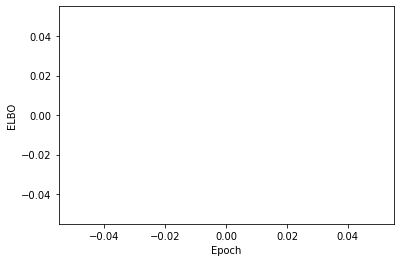

In [ ]:
pf.set_backend("pytorch")
our_bnn_model = train_and_predict_bnn(our_mscn_model, "job-light",10000,100,32,256)

In [ ]:
def predict_bnn(mscn_model, bnn_model, workload_name, method_name):
    # Load training and validation data
    batch_size = 32
    num_materialized_samples = 1000
    dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_data, test_data = get_train_datasets(
        1000, num_materialized_samples)
    table2vec, column2vec, op2vec, join2vec = dicts

    # Load test data
    file_name = "/content/drive/MyDrive/Colab Notebooks/Database_Project/workloads/" + workload_name
    joins, predicates, tables, samples, label = load_data(file_name, num_materialized_samples)

    # Get feature encoding and proper normalization
    samples_test = encode_samples(tables, samples, table2vec)
    predicates_test, joins_test = encode_data(predicates, joins, column_min_max_vals, column2vec, op2vec, join2vec)
    labels_test, _, _ = normalize_labels(label, min_val, max_val)

    
    max_num_predicates = max([len(p) for p in predicates_test])
    max_num_joins = max([len(j) for j in joins_test])

    # Get test set predictions
    test_data = make_dataset(samples_test, predicates_test, joins_test, labels_test, max_num_joins, max_num_predicates)
    test_data_loader = DataLoader(test_data, batch_size=128)
    
    x_test, y_test = get_data_from_dataloader(mscn_model, test_data_loader)
    #x_test = torch.from_numpy(x_test).requires_grad_(False)
    #y_test = torch.from_numpy(y_test).requires_grad_(False)

    preds_test = bnn_model.predict(x_test, method=method_name)

    # Unnormalize
    preds_test_unnorm = unnormalize_labels(preds_test, min_val, max_val)

    # Print metrics
    print("\nQ-Error " + workload_name + ":")
    print_qerror(preds_test_unnorm, label)
    if method_name=="mean":
        # Write predictions
        file_name = "/content/bnn_predictions"+method_name+"_"+ workload_name + ".csv"
        os.makedirs(os.path.dirname(file_name), exist_ok=True)
        with open(file_name, "w") as f:
            for i in range(len(preds_test_unnorm)):
                f.write(str(preds_test_unnorm[i][0]) + "," + label[i] + "\n")
    else:
        # Write predictions
        file_name = "/content/bnn_predictions"+method_name+"_"+ workload_name + ".csv"
        os.makedirs(os.path.dirname(file_name), exist_ok=True)
        with open(file_name, "w") as f:
            for i in range(len(preds_test_unnorm)):
                f.write(str(preds_test_unnorm[i]) + "," + label[i] + "\n")
    
    num_materialized_samples = 1000
    dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_data, test_data = get_train_datasets(
        10000, num_materialized_samples)
    table2vec, column2vec, op2vec, join2vec = dicts

    # Train model
    sample_feats = len(table2vec) + num_materialized_samples
    predicate_feats = len(column2vec) + len(op2vec) + 1
    join_feats = len(join2vec)

    test_data_loader = DataLoader(test_data, batch_size=batch_size)
    x_val, y_val = get_data_from_dataloader(mscn_model, test_data_loader)

    plt.plot([0, 1], [0, 1], "k:", label="Ideal")
    bnn_model.calibration_curve_plot(x_val, y_val, batch_size=10000, label="Our BNN Model") 
    plt.legend()
    plt.show()
    bnn_model.pred_dist_plot(x_test)
    print(bnn_model.pred_dist_covered(x_test, y_test, ci=0.95))
    print(bnn_model.pred_dist_coverage(x_val, y_val, ci=0.95))
    print(bnn_model.pred_dist_coverage(x_test, y_test, ci=0.95))
    print(bnn_model.sharpness(x_val))
    return bnn_model

Loaded queries
Loaded bitmaps
min log(label): 0.0
max log(label): 19.94772801931604
Number of training samples: 900
Number of validation samples: 100
Created TensorDataset for training data
Created TensorDataset for validation data
Loaded queries
Loaded bitmaps

Q-Error job-light:
Median: [1.83912841]
90th percentile: [21.92380892]
95th percentile: [149.76293112]
99th percentile: [1021.28454545]
Max: [2202.]
Mean: [52.98676259]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Loaded queries
Loaded bitmaps
min log(label): 0.0
max log(label): 19.94772801931604
Number of training samples: 9000
Number of validation samples: 1000
Created TensorDataset for training data
Created TensorDataset for validation data


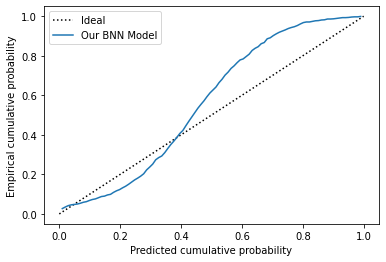

[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]]
0.959
0.8428571428571429
0.13292213


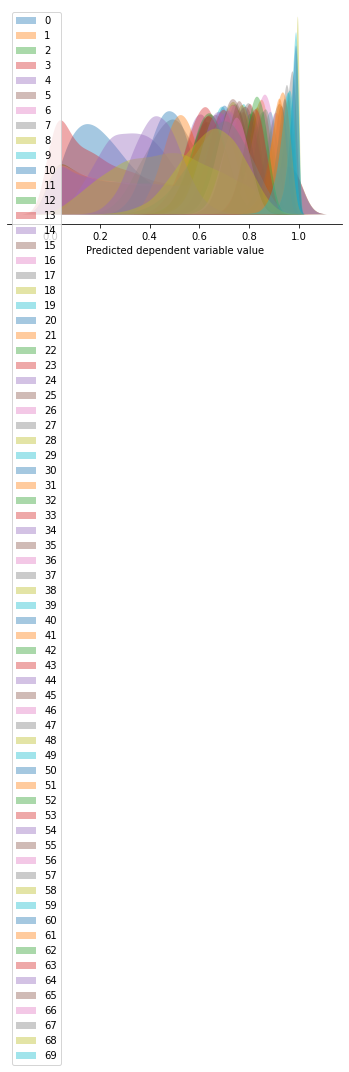

In [ ]:
#predict_bnn(our_mscn_model, our_bnn_model, "job-light", "mode")<= Mode is really not working.
predict_bnn(our_mscn_model, our_bnn_model, "job-light", "mean")

In [ ]:
import pickle
# open a file, where you ant to store the data
file = open('/content/drive/MyDrive/Colab Notebooks/DBSE project_CE/our_bnn_model.pkl', 'wb')

# dump information to that file
pickle.dump(our_bnn_model, file)

# close the file
file.close()

In [ ]:
#pf.utils.io.dump(our_bnn_model, "/content/bnn_model.pf")#Actually we still cannot write to file, maybe if we had trained with a single worker, we would see a difference.
